Many begginers here comparing their result with the leaderboard have the impression that they are doing something wrong, but a result of about 77% is a normal one, the problem is to push it a few percents higher.

This notebook used the standard dataset and scored 0.811 on the leaderboard that puts it in top 1%, if not take in account the top results based on cheating or that used an extended dataset. 

Some feature engineering showed here could be interesting for many beginners as am I by myself, so all the critics, sugestions and rocks of any diameter thrown - are very welcome :)

Have fun!

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import (SimpleImputer, IterativeImputer)
from sklearn.preprocessing import (OneHotEncoder, StandardScaler)
from sklearn.model_selection import (GridSearchCV, cross_val_score)
from sklearn.cluster import KMeans
# from catboost import CatBoostClassifier

In [8]:
# Load data
full_df = pd.read_csv('../train.csv')
test_df = pd.read_csv('../test.csv')

**Analyze data**

In [9]:
full_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
# Separate test_df PassengerId (will need it for submission)
test_pass_id = test_df.pop('PassengerId')

# Keep max index that will be used to back split training and test data
X_max_index = full_df.shape[0]

# Separate features and target
y = full_df.Survived

df = full_df.drop(['Survived', 'PassengerId'], axis=1)
df = pd.concat([df, test_df], axis=0).reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Name      1309 non-null   object 
 2   Sex       1309 non-null   object 
 3   Age       1046 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Ticket    1309 non-null   object 
 7   Fare      1308 non-null   float64
 8   Cabin     295 non-null    object 
 9   Embarked  1307 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 102.4+ KB


- Some features need imputation
- Cabin column has a lot of missing values, we will use the availble 
  values to create a new feature and will drop Cabin
- We will create the feature Deck level, using the correlation between
  Pclass and info deducted from Cabin column. We suppose that the deck 
  level could take a rol in survivability of the people as the lifeboats 
  were on the top level.
- From Name we will keep just the last name and use it during creation 
  of Deck_level.
- We will create the feature Title, extracting the title from Name column, 
  supposing that some people had priority for embarking lifeboats.

**Unprocessed data correlation**



In [5]:
full_df.corr()['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

- Fare and Pclass have the highest correlation to Survived, it seams higher class (also higher Fare) had priority to embarc the lifeboats.
- Pclass has negative correlation because Pclass is numbered 1, 2, 3 (high, medium, low), but results to an invers survivability (class 3 = lower chance to survive, class 1 = higher chance).

**Features' instances**

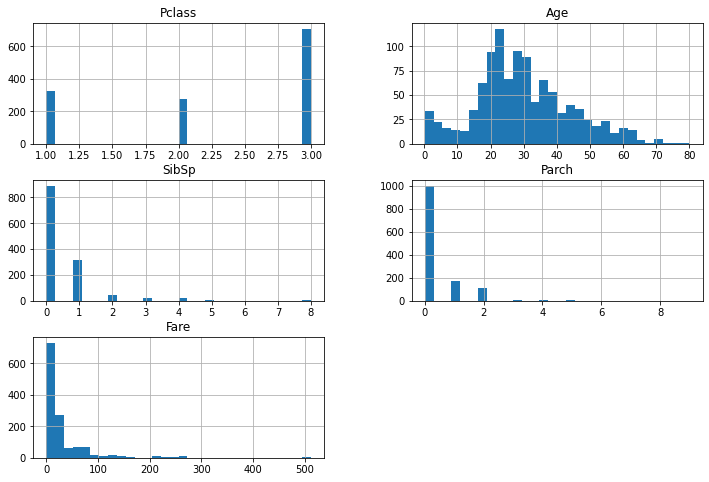

In [6]:
df.hist(bins=30, figsize=(12, 8))
plt.show()

- Attributes have different scales
- Some features are skewed right, we should check for outliers and normalize data
- Fare has values of 0 that looks weird

In [7]:
# Zero values in Fare we will consider as an error or outlier and will delete for further imputation
df.loc[df.Fare == 0, 'Fare'] = np.nan

**Create Lastname feature**

In [8]:
df['Lastname'] = df.Name.str.split(', ').str[0]

**Create 'Title' feature**

In [9]:
# Extracting the Title from Name column
df['Title'] = df.Name.str.split(', ').str[1]
df['Title'] = df.Title.str.split('.').str[0]

In [10]:
# Analyze titles
df.Title.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Title, dtype: int64

There are some title with the same meaning that should be joined together and also many unique titles that we will group under the title 'Noble'

In [11]:
# Analyze the title Mr and the Age
df[df.Title == 'Mr'].Age.describe()

count    581.000000
mean      32.252151
std       12.422089
min       11.000000
25%       23.000000
50%       29.000000
75%       39.000000
max       80.000000
Name: Age, dtype: float64

In [12]:
# Analyze the title Master and the Age
df[df.Title == 'Master'].Age.describe()

count    53.000000
mean      5.482642
std       4.161554
min       0.330000
25%       2.000000
50%       4.000000
75%       9.000000
max      14.500000
Name: Age, dtype: float64

Title Mr was used from 11 years old and Master to maximum 15 years old. 
Master is an antiquated title for an underage male.
We will join them together and then split again at age 18 to have a clean delimeter.

In [13]:
# Grouping the same type titles 

# We change also Miss to Mrs, but later we will convert back 
# to Miss just for underage females as for now Miss is not 
# very usefull as it represents a young lady and also 
# an unmarried adult one of any age
females = ['Ms', 'Miss', 'Mlle', 'Mrs', 'Mme']
df.loc[df.Title.isin(females), 'Title'] = 'Mrs'

males = ['Master', 'Mr']
df.loc[(df.Title.isin(males)), 'Title'] = 'Mr'

# Change the titles for underage persons to Master and Miss
df.loc[((df.Title == 'Mr') & (df.Age < 18)), 'Title'] = 'Master'
df.loc[((df.Title == 'Mrs') & (df.Age < 18)), 'Title'] = 'Miss'

# Create noble title
df.loc[(~df.Title.isin(females) & ~df.Title.isin(males)), 'Title'] = 'Noble'

**Create Price feature**

We should divide the Fare by number of passengers on the same ticket

In [14]:
# Analyze Fare by ticket number
# Just to be sure that the Fare represents the full price 
# of the ticket and not the price per person

# Split Ticket by series and number
df['Ticket_series'] = [i[0] if len(i) > 1 else 0 for i in df.Ticket.str.split()]
df['Ticket_nr'] = [i[-1] for i in df.Ticket.str.split()]

# Check if Fare min and Fare max of the same ticket number are the same
df_fare = df[~df.Fare.isna()]
multi_tickets = df_fare.groupby(df_fare.Ticket_nr[df_fare.Ticket_nr.duplicated()])
(multi_tickets.Fare.min() != multi_tickets.Fare.max()).sum()

1

There is just 1 ticket where min and max don't corespond, we will ignore it as a mistake

In [15]:
# Create a column with the passengers number by ticket 
ticket_dict = df.groupby('Ticket_nr').Lastname.count().to_dict()
df['Passengers_ticket'] = df.Ticket_nr.map(ticket_dict)

# Create Price column
df['Price'] = (df.Fare / df.Passengers_ticket).round()

**Create Deck feature**

This will have the deck letter

In [16]:
# Extract Deck letter from Cabin column
df['Deck'] = df.Cabin.str[0]

# Check how many missing values we have at this step
df.Deck.isna().sum()

1014

In [17]:
# Deck distribution by Pclass
df.groupby('Pclass').Deck.value_counts()

Pclass  Deck
1       C       94
        B       65
        D       40
        E       34
        A       22
        T        1
2       F       13
        D        6
        E        4
3       F        8
        G        5
        E        3
Name: Deck, dtype: int64

In [18]:
# Deck missing values by Pclass
df.loc[df.Deck.isna(), 'Pclass'].value_counts()

3    693
2    254
1     67
Name: Pclass, dtype: int64

- On the 1st step we will impute the Deck letter based on Ticket_nr, if the same Ticket_nr has already an available 
  value for Deck in other rows
  
- On the 2nd step we will impute based on Lastname using the same method as in the first step, but to be sure that 
  the passengers are not from different families with the same Lastname we will use some filters in the process.

- On the 3rd step we will impute based on Pclass, as every Pclass was on separate Deck with some intersections between 
  (some googling confirms that class-deck distribution corresponds to our Deck distribution by Pclass analysis). 
  To improve the accuracy we will check also the mean Price for each Pclass-Deck group to determine the Deck. 

In [19]:
# Function for imputing Deck
def impute_deck_by(feature):
    for pclass in range(1, 4):
        # Create a mapping dictionary
        map_dic = (df[~df.Deck.isna() 
                      & (df.Pclass == pclass)]
                       .groupby(feature)
                       .Deck.unique()
                       .apply(list).to_dict())

        # Keep just the keys with a single deck to avoid 
        # the same key on different decks
        map_dic = {i:j[0] for i, j in map_dic.items() 
                   if len(j) == 1}

        # Imputing Deck from map_dic
        df.loc[df.Deck.isna() & (df.Pclass == pclass), 
               'Deck'] = df[feature].map(map_dic)

    # Check how many missing values we have at this step
    print(df.Deck.isna().sum())

In [20]:
impute_deck_by('Ticket_nr')

997


In [21]:
impute_deck_by('Lastname')

989


We have recovered 25 values, not much, but they correspond to reality,
the rest we will impute later based on Pclass and Price as mentioned earlier.

**Analyze and impute missing prices**

We impute prices first as there are less missing values in Price than in Deck and we use them both for imputation

In [22]:
# Analyze Price by Deck and Pclass
df.groupby(['Pclass', 'Deck']).Price.describe()

count       mean        std   min    25%   50%   75%    max
Pclass Deck                                                             
1      A      21.0  32.857143   7.066015  26.0  28.00  30.0  36.0   50.0
       B      65.0  43.030769  25.892789   5.0  29.00  37.0  46.0  128.0
       C     105.0  35.809524   9.686524  25.0  28.00  34.0  42.0   68.0
       D      42.0  31.904762   9.714986  20.0  26.00  27.5  38.0   67.0
       E      35.0  26.342857   5.058149   9.0  26.50  27.0  28.0   38.0
       T       1.0  36.000000        NaN  36.0  36.00  36.0  36.0   36.0
2      D       6.0  13.666667   0.816497  13.0  13.00  13.5  14.0   15.0
       E       6.0   9.500000   3.619392   5.0   6.25  11.0  12.0   13.0
       F      16.0  10.937500   1.691892   9.0  10.00  10.0  13.0   13.0
3      E       3.0   6.666667   1.154701   6.0   6.00   6.0   7.0    8.0
       F      11.0   7.545455   0.522233   7.0   7.00   8.0   8.0    8.0
       G       5.0   5.600000   0.547723   5.0   5.00   6.0   6.0    6.0

Very large standard deviation in Pclass 1, Deck B comparing to others, we should analyze this. Also we will take a look into Deck C

In [23]:
# Cabin T was on the upper deck (google helps), 
# so we will replace it with A deck as it has just a single value
df.loc[df.Deck == 'T', 'Deck'] = 'A'

In [24]:
# Check the cheapest prices for Deck B
df[df.Deck == 'B'].sort_values('Price').head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Lastname,Title,Ticket_series,Ticket_nr,Passengers_ticket,Price,Deck
872,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0,B51 B53 B55,S,Carlsson,Mr,0,695,1,5.0,B
690,1,"Dick, Mr. Albert Adrian",male,31.0,1,0,17474,57.0,B20,S,Dick,Mr,0,17474,3,19.0,B
781,1,"Dick, Mrs. Albert Adrian (Vera Gillespie)",female,17.0,1,0,17474,57.0,B20,S,Dick,Miss,0,17474,3,19.0,B
1199,1,"Hays, Mr. Charles Melville",male,55.0,1,1,12749,93.5,B69,S,Hays,Mr,0,12749,4,23.0,B
1281,1,"Payne, Mr. Vivian Ponsonby",male,23.0,0,0,12749,93.5,B24,S,Payne,Mr,0,12749,4,23.0,B


In [25]:
# Maybe Mr Carlsson paid just 5 pounds for that 1st class ticket, 
# but this value is an outlier that we will replace with the next min
df.loc[(df.Ticket_nr == '695'), 'Price'] = 19

In [26]:
# Check the most expensive prices for Deck B
df[df.Deck == 'B'].sort_values('Price', ascending=False).head(10)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Lastname,Title,Ticket_series,Ticket_nr,Passengers_ticket,Price,Deck
1234,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.0,0,1,PC 17755,512.3292,B51 B53 B55,C,Cardeza,Mrs,PC,17755,4,128.0,B
258,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,Ward,Mrs,PC,17755,4,128.0,B
737,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C,Lesurer,Mr,PC,17755,4,128.0,B
679,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,Cardeza,Mr,PC,17755,4,128.0,B
118,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C,Baxter,Mr,PC,17558,3,83.0,B
1075,1,"Douglas, Mrs. Frederick Charles (Mary Helene B...",female,27.0,1,1,PC 17558,247.5208,B58 B60,C,Douglas,Mrs,PC,17558,3,83.0,B
299,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.0,0,1,PC 17558,247.5208,B58 B60,C,Baxter,Mrs,PC,17558,3,83.0,B
730,1,"Allen, Miss. Elisabeth Walton",female,29.0,0,0,24160,211.3375,B5,S,Allen,Mrs,0,24160,4,53.0,B
1215,1,"Kreuchen, Miss. Emilie",female,39.0,0,0,24160,211.3375,NaN,S,Kreuchen,Mrs,0,24160,4,53.0,B
779,1,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",female,43.0,0,1,24160,211.3375,B3,S,Robert,Mrs,0,24160,4,53.0,B


In [27]:
# Two most expensive tickets are outliers,
# we will cap them at the next overall highest Price 
df.loc[(df.Ticket_nr == '17755'), 'Price'] = 68
df.loc[(df.Ticket_nr == '17558'), 'Price'] = 68

In [28]:
# Create a data frame of mean prices by Pclass and Deck 
class_deck_price = pd.DataFrame(df.groupby(['Pclass', 'Deck'])
                                .Price.mean().round(2)).reset_index()

# Impute missing prices 
# Where Deck is missing we will use the mean price by Pclass only
for index, row in df.loc[df.Price.isna(), 
                         ['Pclass', 'Deck']].iterrows():
    if not pd.isna(row.Deck):
        new_price = class_deck_price.loc[
            ((class_deck_price.Pclass == row.Pclass) 
            & (class_deck_price.Deck == row.Deck)), 'Price'].mean()
    else:
        new_price = class_deck_price[
            class_deck_price.Pclass == row.Pclass].Price.mean()

    df.loc[[index], 'Price'] = new_price

**Analyze and impute missing Deck**

In [29]:
# Create dictionaries with aproximative price ranges by deck 
# concluded from previous analisys
first_cl = {'A': [25, 30],
            'B': [35, 70],
            'C': [30, 35],
            'D': [19, 25],
            'E': [9, 19]}

second_cl = {'D': [13, 17],
             'E': [5, 9],
             'F': [9, 13]}

third_cl = {'E': [8, 9],
            'F': [9, 21],
            'G': [0, 8]}

# Create a dictionary pairing Pclass and respective price dictionary
class_dict = {1: first_cl,
              2: second_cl,
              3: third_cl}

# Impute missing Deck values 
for index, row in df.loc[df.Deck.isna(), ['Pclass', 'Price']].iterrows():
    for c, d in class_dict.items():
        if row.Pclass == c:
            for i, j in d.items():
                if max(j) > row.Price >= min(j):
                    df.loc[[index], 'Deck'] = i

# Encode Deck with it's deck level number counting from the bottom
deck_level = {'G': 1, 'F': 2, 'E': 3, 'D': 4, 'C': 5, 'B': 6, 'A': 7}

df.Deck = df.Deck.replace(deck_level)

**Create 'Escape_density' feature**

Crowded decks could lead to jams and chaos when everybody wanted to go to the upper deck as the lifeboats were there.
This feature will show through which amount of people each deck passenger needed to pass to arrive on top. 
Basically for each deck we will have a number of people equal to the summ of its own value and all the decks that are upper from it.

In [30]:
# Analyse how many people were on each deck.
# Many values were imputed with aproximation,but at least we will have 
# an aproximative crowd mass each passenger has to pass going up
deck_people = df.Deck.value_counts().sort_index().to_dict()
deck_people

{1: 283, 2: 202, 3: 408, 4: 176, 5: 116, 6: 76, 7: 48}

In [31]:
# Create an escape density dictionary from which we will impute data to our new feature
escape_density = {}
for i in range(1, 8):
    escape_density[i] = sum(deck_people.values())
    del deck_people[i]
    
escape_density

{1: 1309, 2: 1026, 3: 824, 4: 416, 5: 240, 6: 124, 7: 48}

In [32]:
# Create Escape_density column
df['Escape_density'] = df.Deck.replace(escape_density)

**Create Family_size feature**

It will represent how big the family was

In [33]:
# We add together the person and his SibSp and Parch
df['Family_size'] = 1 + df.SibSp + df.Parch

**Create Family_survivers**

This feature can't be used for modeling as it will provide target leakage, but by analysing it later we can separate families that could have higher surviving chance

In [1]:
# Create full data frame for analysis
X = df[:X_max_index]
test_df = df[X_max_index:].copy()
full_df = pd.concat([X, y], axis=1).copy()

# Check for families that has survivers and create a dictionary with mean value of their family survivability
family_survivers = full_df[['Lastname', 'Survived']].groupby('Lastname').mean().round(2).reset_index()
family_survivers_dict = dict(zip(family_survivers.Lastname, family_survivers.Survived))

# Reduce the dictionary to the list of families that are both in train and test data
common_survivers = {}
for lastname, survived in family_survivers_dict.items():
    if lastname in list(test_df['Lastname'].unique()):
        common_survivers[lastname] = survived

# Create Family_survivers feature
test_df['Family_survivers'] = test_df.Lastname.map(common_survivers)
full_df['Family_survivers'] = full_df.Lastname.map(common_survivers)

# For the families that are not present in both train and test we will impute the overall mean value
test_df.Family_survivers = test_df.Family_survivers.fillna(test_df.Family_survivers.mean())
full_df.Family_survivers = full_df.Family_survivers.fillna(full_df.Family_survivers.mean())

# Separate back features and target
y = full_df.Survived

df = full_df.drop('Survived', axis=1)
df = pd.concat([df, test_df], axis=0).reset_index(drop=True)

NameError: name 'df' is not defined

**Clean data**

In [35]:
# Change Pclass dtype to category as it's a classification feature
df.Pclass = df.Pclass.astype('category')

In [36]:
# Drop further unused columns
col_drop = ['Name', 'Ticket', 'Fare', 'Cabin', 'Lastname','Ticket_nr',  
            'Ticket_series', 'Passengers_ticket']
df = df.drop(col_drop, axis=1)

**Impute categorical features**

In [37]:
# List of categorical columns
categ_cols = list(df.select_dtypes(['object', 'category']).columns)

# Impute categoricals with most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')

df_cat = cat_imputer.fit_transform(df[categ_cols])
df_cat = pd.DataFrame(df_cat, columns=df[categ_cols].columns)

**Encode categorical features**

In [38]:
# Encode categoricals with One Hot Encoding
ohe = OneHotEncoder(sparse=False)

df_cat = pd.DataFrame(ohe.fit_transform(df_cat),
                  columns=ohe.get_feature_names_out())

**Impute numericals**

In [39]:
# List of numerical columns
num_cols = [col for col in df.columns 
            if df[col].dtype in ['int64', 'float64']]

# Impute numericals
it_imp = IterativeImputer()

df_num = pd.DataFrame(it_imp.fit_transform(df[num_cols]),
                      columns=df[num_cols].columns)

# Concatenate with encoded categorical columns
df = pd.concat([df_cat, df_num], axis=1)

**Feature engineering**

In [40]:
# Create a full data frame for analysis
X = df[:X_max_index]
full_df = pd.concat([X, y], axis=1)

In [41]:
# Function for kde plotting
def survive_chance_by(feature, xticks=None, xlim=None):
    survived = full_df[full_df.Survived == 1]
    not_survived = full_df[full_df.Survived == 0]

    plt.figure(figsize=(10, 5))

    survived[feature].plot(kind='kde', label='survived')
    not_survived[feature].plot(kind='kde', label='not_survived')
    
    plt.xlim(xlim)
    plt.xticks(xticks)
    plt.legend()
    plt.grid()
    plt.xlabel(feature)
    plt.show()

**Create Age_group feature**

This feature wasn't used for the top score as it gave a slightly lower score, but I leave it here in a markdown cell for learning purposes

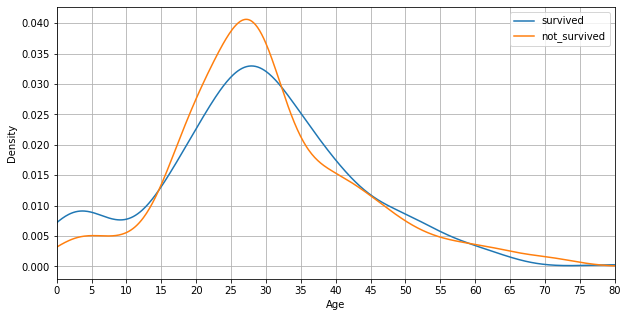

In [42]:
# Survivers by Age
survive_chance_by('Age', np.arange(0, 81, 5), (0, 80))

By curves intersection points we can separate 4 age groups:
    
    1. 0-16 years old have higher survivability chance
    2. 16-27 years old lower chance
    3. 27-39 years old even lower chance
    4. For the rest the chances are almost equal

df['Age_group'] = pd.cut(x=df.Age, bins=[0, 16, 27, 39, df.Age.max()],
                         labels=['Child', 'Young', 'Adult', 'Old'])

**Create Family_group feature**

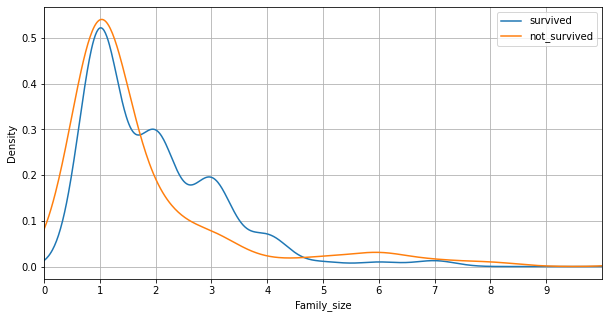

In [43]:
# Survivers by Family_size
survive_chance_by('Family_size', np.arange(0, 10, 1), (0, 10))

Here we can separate 3 groups:

    1. Single persons had lower chance to survive
    2. 2-4 members families had higher chances, as they had some priority to safeboats with 1-2 children with them
    3. 5 and more members families had almost equal chances

In [44]:
# Create Family_group feature
df['Family_group'] = pd.cut(x=df.Family_size, 
                            bins=[0, 1, 4, df.Family_size.max()],
                            labels=['Single', 'Medium', 'Large'])

**Create Lucky_family feature**

To create this feature we analyse earlier created Family_survivers that used by itself would overfit the model

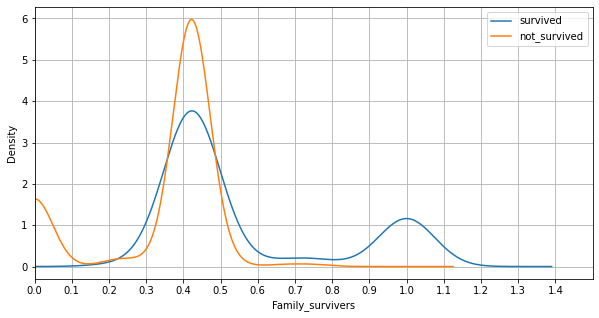

In [45]:
# Survivers by Family_survivers
survive_chance_by('Family_survivers', np.arange(0, 1.5, 0.1), (0, 1.5))

In [46]:
# Create Lucky_family feature
df['Lucky_family'] = pd.cut(x=df.Family_survivers, 
                            bins=[0, 0.22, 0.35, 0.49, df.Family_survivers.max()],
                            labels=['Low', 'Medium', 'Very_low', 'High'])

In [47]:
# Encode categoricals
df = pd.get_dummies(df)

**Standardization**

In [48]:
# Apply np.log to normalize the skewed right Price
df.Price = df.Price.apply(np.log1p)

# Standardize 
std_scaler = StandardScaler()

df_scaled = std_scaler.fit_transform(df)
df = pd.DataFrame(df_scaled, columns=df.columns)

In [49]:
# Drop features not used for modeling
cols_to_drop = ['Family_survivers', 'SibSp', 'Parch', 'Family_size']
df = df.drop(cols_to_drop, axis=1)

**Split train and test data**

In [50]:
X = df[:X_max_index]
test_df = df[X_max_index:]

**Processed data correlation**

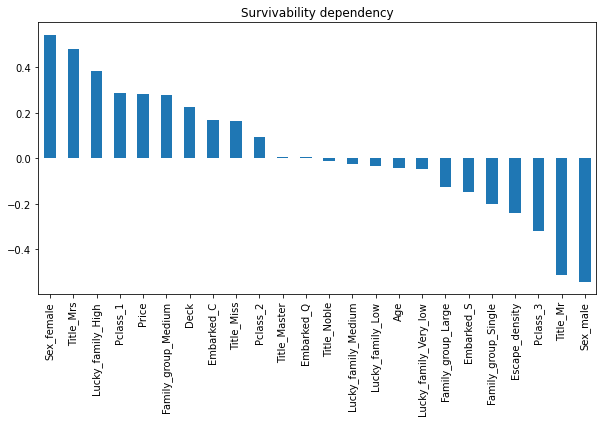

In [51]:
# Concatenate into a full dataset
full_df = pd.concat([X, y], axis=1)

correlation = full_df.corr()['Survived'].sort_values(ascending=False)

# Correlation graph
correlation[1:].plot(kind='bar', figsize=(10,5), title='Survivability dependency')
plt.show()

**Conclusion:**

On the Titanic is better to not be an usual single adult male on a lower deck and embarked from Southampton with a cheap ticket in the pocket - RIP Jack Dawson :-(

**CatBoost grid search parameter tuning**

In [52]:
# Define model
cat_model = CatBoostClassifier()

# Define parameters' grid
grid = {'verbose': [False],
        'thread_count': [-1],
        'depth': [4, 5],
        'iterations': [2000, 3000],
        'learning_rate': [0.0001, 0.0003]}

# Define GridSearchCV
grid_cat = GridSearchCV(estimator=cat_model, param_grid=grid, cv=3, n_jobs=-1)
grid_cat.fit(X, y)

print('Results from Grid Search')
print('\n Best Score:\n', grid_cat.best_score_)
print('\n Best parameters:\n', grid_cat.best_params_)

Results from Grid Search

 Best Score:
 0.8383838383838383

 Best parameters:
 {'depth': 4, 'iterations': 3000, 'learning_rate': 0.0003, 'thread_count': -1, 'verbose': False}


**CatBoost model test**

In [53]:
# Define parameters
# They were manualy adjusted after grid search as gave a better leaderboard score
params = {'depth': 4, 
          'iterations': 1000, 
          'learning_rate': 0.0001, 
          'thread_count': -1, 
          'verbose': False}

# Define and fit the model
cat_model = CatBoostClassifier(**params)
cat_model.fit(X, y)

# Check accuracy and features importance
cat_rmses = cross_val_score(cat_model, X, y, cv=5)

print(pd.Series(cat_rmses).describe())
print('\n', cat_model.get_feature_importance(prettified=True))

count    5.000000
mean     0.822641
std      0.019584
min      0.803371
25%      0.803371
50%      0.825843
75%      0.831461
max      0.849162
dtype: float64

                Feature Id  Importances
0                Sex_male    21.841377
1              Sex_female    20.690120
2       Lucky_family_High    19.887859
3                Title_Mr    10.087607
4                Pclass_3     6.886640
5                   Price     4.536172
6   Lucky_family_Very_low     3.395928
7      Family_group_Large     2.675349
8          Escape_density     1.819732
9                    Deck     1.819502
10               Pclass_1     1.630287
11                    Age     1.554983
12              Title_Mrs     1.128956
13    Family_group_Medium     0.556310
14               Pclass_2     0.514946
15           Title_Master     0.279859
16    Family_group_Single     0.273912
17            Title_Noble     0.088251
18             Title_Miss     0.085064
19             Embarked_C     0.081789
20             Embar

**Scoring**

In [54]:
# Make predictions which we will submit.
test_preds = cat_model.predict(test_df)

# Save predictions in the format used for competition scoring
output = pd.DataFrame({'PassengerId': test_pass_id,
                       'Survived': test_preds})
output.to_csv('submission.csv', index=False)